In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import mysql.connector

from IPython.display import display, Markdown, HTML

pd.set_option('display.max_rows', 750)


db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="secret",
    port="3306",
    database="serlo"
)

def cached(func):
    cache = dict()
    
    def return_func(arg="__default"):
        if (arg in cache):
            return cache[arg]
        else:
            if arg == "__default":
                result = func()
            else:
                result = func(arg)
            cache[arg] = result
            return result
    
    return return_func

def query(sql):
    c = db.cursor()
    c.execute(sql)
    
    return c.fetchall()

def querySingleton(sql):
    return [ x[0] for x in query(sql) ]

In [52]:
@cached
def getParent(termId):
    return querySingleton("""
        select parent_id from term_taxonomy where id = %s;
    """ % termId)[0]

def getTermName(termId):
    return querySingleton("""
        select term.name from term_taxonomy
        join term on term.id = term_taxonomy.term_id
        where term_taxonomy.id = %s;
    """ % termId)[0]

@cached
def getSubject(termId):
    if int(termId) in [79733, 81317, 20852, 87814, 87827, 85477, 87860, 75049, 76750, 87496, 75678, 91252, 91253]:
        return "Prüfungsbereich Mathematik"
    if int(termId) in [106082]:
        return getTermName(termId)
    
    parent = getParent(termId)
    grandparent = getParent(parent)
    
    if (parent == 106081):
        return getTermName(termId)
    
    return getSubject(parent) if grandparent != None else getTermName(termId)

@cached
def getSubjectFromUuid(uuid):
    taxonomyTerms = querySingleton(f"""
        select term_taxonomy_id from term_taxonomy_entity
        where term_taxonomy_entity.entity_id  = {uuid};
    """)
    
    if len(taxonomyTerms) > 0:
        return getSubject(taxonomyTerms[0])

    parents = querySingleton(f"""
        select parent_id from entity_link
        where entity_link.child_id  = {uuid};
    """)
    
    if len(parents) > 0:
        return getSubjectFromUuid(parents[0])
    
    return None

# Read in User Data and Eventlog

In [53]:
user_df = pd.read_sql("""
        select
        id, username, date, last_login, DATE_FORMAT(date, '%m/%d/%Y')
    from 
        user
    where 
        date BETWEEN CURDATE() - INTERVAL 90 DAY AND CURDATE();
    """, db)

In [54]:
# Liste aller neuen Nutzer*Innen, die seit den letzten 90 Tagen dazu gekommen sind
new_user_list = list(user_df.id.unique())

In [55]:
def read_event_log():
    df = pd.read_sql("""
        select event_log.id, event_log.actor_id, event_log.date, user.username, event_parameter_uuid.uuid_id from event_log
        join user on user.id = event_log.actor_id
        join event_parameter on event_parameter.log_id = event_log.id
        join event_parameter_uuid on event_parameter_uuid.event_parameter_id = event_parameter.id
        where event_log.event_id = 5
        and year(event_log.date) > 2018
        and user.username != "Legacy"
    """, db)
    df.set_index("id", inplace=True)
    df.rename(columns={"uuid_id": "uuid"}, inplace=True)
    df["subject"] = df["uuid"].map(getSubjectFromUuid)
    return df

event_log = read_event_log()
event_log.head(100)

,actor_id,date,username,uuid,subject
id,,,,,
252170,95850,2019-01-02 10:35:03,Leo1,127338,Chemie
252172,95850,2019-01-02 10:58:42,Leo1,127338,Chemie
252180,95849,2019-01-02 11:46:55,hernlmax,63496,Chemie
252185,95849,2019-01-02 11:51:49,hernlmax,127428,Chemie
252187,95849,2019-01-02 11:52:47,hernlmax,127428,Chemie
252189,95849,2019-01-02 11:53:00,hernlmax,127428,Chemie
252194,95849,2019-01-02 11:54:28,hernlmax,127428,Chemie
252196,95849,2019-01-02 11:56:19,hernlmax,127355,Chemie
252198,95849,2019-01-02 12:12:57,hernlmax,127432,Chemie


In [56]:
# Alle Bearbeitungen in den letzten 90 Tagen 
date_limit = pd.Timestamp.today() - pd.Timedelta(days = 90)
edits_df = event_log[date_limit < event_log['date']] 
edits_list = list(edits_df.uuid.unique())
#print(f"Anzahl bearbeiteter Inhalte: {len(edits_list)}")
#print(edits_list)

## Anzahl und Namen der UserInnen, die sich in den letzten 90 Tagen registriert haben

In [57]:
user_df[['id', 'username', 'date', 'last_login']]

,id,username,date,last_login
0,244438,KarinL,2022-04-27 09:30:49,2022-04-27 09:34:49
1,244443,schmaro,2022-04-27 09:47:59,NaT
2,244493,aemoutsource,2022-04-27 11:44:21,2022-04-27 11:45:02
3,244509,Daviddavid,2022-04-27 13:00:25,2022-04-27 13:00:54
4,244561,Eleni_P,2022-04-28 07:32:39,2022-04-28 15:41:56
5,244564,emilyec9,2022-04-28 08:41:39,2022-04-28 08:42:22
6,244567,fonteku,2022-04-28 10:12:40,2022-04-28 10:16:27
7,244573,MaWi,2022-04-28 11:27:49,2022-04-28 11:30:52
8,244591,Cancompare,2022-04-28 15:41:09,NaT
9,244612,GJB563,2022-04-28 21:07:19,NaT


## Anzahl und Namen der AutorInnen, die seit den letzten 90 Tagen Bearbeitungen gemacht haben

In [58]:
#Liste aller AutorInnen, die Bearbeitungen seit den letzten 90 Tagen ausgeführt haben.
author_list = list(edits_df.actor_id.unique())
print(f"Anzahl der AutorInnen: {len(author_list)}")
#Namen der AutorInnen, die die Bearbeitungen ausgeführt haben
user_df[user_df['id'].isin(author_list)]

Anzahl der AutorInnen: 53


,id,username,date,last_login,"DATE_FORMAT(date, '%m/%d/%Y')"
56,245127,Alisa13,2022-05-05 17:08:13,2022-05-05 17:08:45,05/05/2022
69,245335,Noravschenck,2022-05-09 09:38:44,2022-05-09 09:39:04,05/09/2022
70,245374,rabaer95,2022-05-09 11:07:52,2022-05-09 11:08:28,05/09/2022
75,245430,nicohue,2022-05-09 18:24:14,2022-05-10 10:14:14,05/09/2022
82,245439,katharina_hauck,2022-05-10 08:47:35,2022-05-10 08:48:24,05/10/2022
84,245442,matheprofi123,2022-05-10 09:12:59,2022-05-10 09:15:38,05/10/2022
86,245444,tvetter17,2022-05-10 09:25:50,2022-05-10 10:39:29,05/10/2022
106,245608,janice,2022-05-12 19:39:59,2022-06-10 16:40:07,05/12/2022
138,245960,JessiLo,2022-05-18 09:23:45,2022-05-18 09:48:17,05/18/2022
156,246285,Ramanujan,2022-05-22 17:59:45,2022-05-22 18:01:30,05/22/2022


In [59]:
#Berechnung aktiver Autor*Innen von heute aus 
days = 90
edits = 10
result_df = pd.DataFrame()
week = 0
  
lower_date = pd.Timestamp.today() - pd.Timedelta(days = days + week*7)
upper_date = pd.Timestamp.today() - pd.Timedelta(days = week*7)
 
df1 = event_log[lower_date < event_log['date']] 
df2 = df1.groupby(by = ['actor_id'], as_index = False).count()
df3 = df2[df2['uuid'] >= edits]
df3 = df3.drop(['date', 'username', 'uuid'], axis = 1)

active_authors_df = df3.rename(columns={"actor_id": "active_authors"})
#active_authors_df = active_authors_df.sort_values(by = ['active_authors'], ascending=False)
#display(Markdown(f"### Anzahl aktiver Autor:Innnen pro Fach"))
editing_users_list = list(df2.actor_id)
active_authors_list = list(active_authors_df.active_authors)

In [60]:
new_editing_users_list = set(editing_users_list) & set(new_user_list)

In [61]:
new_active_authors_list = set(active_authors_list) & set(new_user_list)

## Liste aller neuen NutzerInnen in den letzten 90 Tagen mit mindestens einer Bearbeitung

In [62]:
user_df[user_df['id'].isin(new_editing_users_list)][['id', 'username', 'date', 'last_login']]

,id,username,date,last_login
56,245127,Alisa13,2022-05-05 17:08:13,2022-05-05 17:08:45
69,245335,Noravschenck,2022-05-09 09:38:44,2022-05-09 09:39:04
70,245374,rabaer95,2022-05-09 11:07:52,2022-05-09 11:08:28
75,245430,nicohue,2022-05-09 18:24:14,2022-05-10 10:14:14
82,245439,katharina_hauck,2022-05-10 08:47:35,2022-05-10 08:48:24
84,245442,matheprofi123,2022-05-10 09:12:59,2022-05-10 09:15:38
86,245444,tvetter17,2022-05-10 09:25:50,2022-05-10 10:39:29
106,245608,janice,2022-05-12 19:39:59,2022-06-10 16:40:07
138,245960,JessiLo,2022-05-18 09:23:45,2022-05-18 09:48:17
156,246285,Ramanujan,2022-05-22 17:59:45,2022-05-22 18:01:30


## Liste aller neuen aktiven AutorInnen in den letzten 90 Tagen

In [63]:
user_df[user_df['id'].isin(new_active_authors_list)][['id', 'username', 'date', 'last_login']]

,id,username,date,last_login
82,245439,katharina_hauck,2022-05-10 08:47:35,2022-05-10 08:48:24
210,247271,Lilith_Diringer,2022-05-31 17:13:13,2022-07-04 20:39:22


In [64]:
# Aggregate over week to show graph
weekly_df = user_df.groupby(pd.Grouper(freq='W', key='date'))['username'].count().reset_index()

In [65]:
weekly_df

,date,username
0,2022-05-01,26
1,2022-05-08,40
2,2022-05-15,56
3,2022-05-22,35
4,2022-05-29,38
5,2022-06-05,29
6,2022-06-12,34
7,2022-06-19,44
8,2022-06-26,41
9,2022-07-03,39


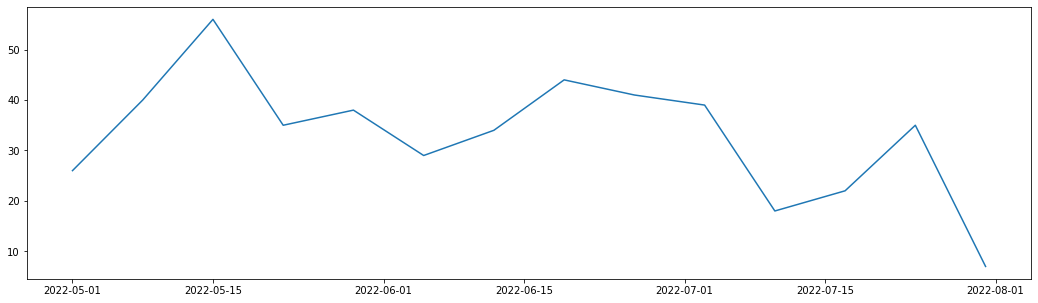

In [66]:
plt.rcParams["figure.figsize"] = (18,5)
plt.plot(weekly_df["date"], weekly_df["username"])
plt.show()